In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv',header = None)
data.columns = ['timestamp','time','id','return']
data['return'] = np.exp(data['return']) - 1
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [2]:
mask = (data['timestamp'] >= pd.to_datetime("1996/01/01")) & (data['timestamp'] <= pd.to_datetime("2001/12/31"))
data = data[mask]

In [3]:
market_return = data.groupby('timestamp').agg({'return':'mean','id':'count'}).reset_index()
market_return.columns = ['timestamp','market_return','N']

In [4]:
market_return
data = pd.merge(data, market_return, 'left', on = ['timestamp'])

In [5]:
data['excess_return'] = data['return'] - data['market_return']
data['w1'] = -1/690 * (data['return'] - data['market_return'])
data['w1_real'] = data.groupby('id')['w1'].shift(1)
data['r1'] = data['w1_real']*data['return']
portfolio_returns = data.groupby('timestamp').agg({'r1':'sum'})
portfolio_returns.columns = ['return']

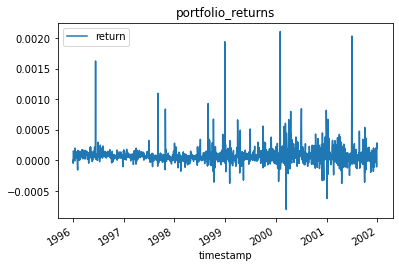

mean: 2.01%
std: 0.25%
sr:8.18


In [6]:
portfolio_returns.plot()
plt.title("portfolio_returns")
plt.show()
print("mean: {:.2%}".format(portfolio_returns.mean()[0]*252))
print("std: {:.2%}".format(portfolio_returns.std()[0]*np.sqrt(252)))
print("sr:{:.2f}".format(portfolio_returns.mean()[0] / portfolio_returns.std()[0] * np.sqrt(252)))

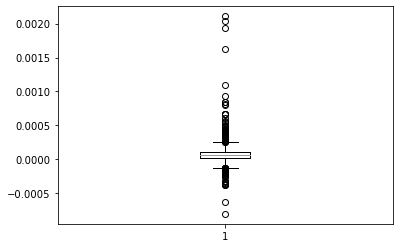

In [7]:
plt.boxplot(portfolio_returns['return'])
plt.show()

In [8]:
mu = portfolio_returns['return'].mean()
sigma = portfolio_returns['return'].std()

normal_port = portfolio_returns[(portfolio_returns['return'] > mu - 3*sigma)&(portfolio_returns['return'] < mu + 3*sigma)]

normal_port.mean()/normal_port.std()*np.sqrt(252)

return    11.140832
dtype: float64

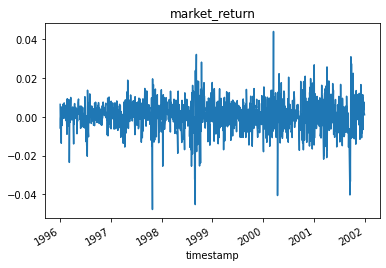

mean: 17.41%
std: 12.41%
sr:1.40


In [9]:
market_return = market_return.set_index('timestamp',drop = True)
market_return['market_return'].plot()
plt.title("market_return")
plt.show()
print("mean: {:.2%}".format(market_return['market_return'].mean()*252))
print("std: {:.2%}".format(market_return['market_return'].std()*np.sqrt(252)))
print("sr:{:.2f}".format(market_return['market_return'].mean() / market_return['market_return'].std() * np.sqrt(252)))

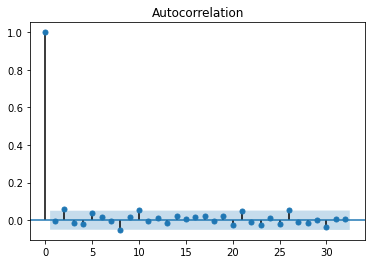

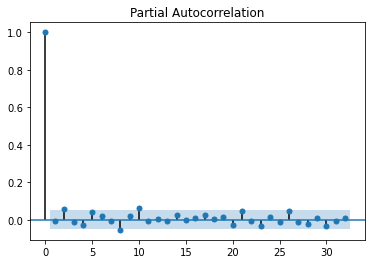

In [10]:
sm.graphics.tsa.plot_acf(portfolio_returns)
plt.show()

sm.graphics.tsa.plot_pacf(portfolio_returns)
plt.show()

In [11]:
market_return['market_return'].corr(portfolio_returns['return'])

0.08932883843247433

In [12]:
long = data[data['w1_real'] > 0]
short = data[data['w1_real'] < 0]

long_portfolio =  long.groupby('timestamp').agg({'r1':'sum'})
short_portfolio = short.groupby('timestamp').agg({'r1':'sum'})


In [13]:
long_portfolio['r1'].corr(short_portfolio['r1'])

-0.35355850186621407

# Q2

In [14]:
data = data.set_index('timestamp',drop=True)

In [15]:
def generate_info(k):
    real_weight = data.groupby('id')['w1'].shift(k)
    data['daily_returns'] = real_weight*data['return']
    portfolio_returns = data.groupby('timestamp').agg({'daily_returns':'sum'})
    return portfolio_returns['daily_returns'].mean()*252, portfolio_returns['daily_returns'].std() * np.sqrt(252),portfolio_returns['daily_returns'].mean() / portfolio_returns['daily_returns'].std() * np.sqrt(252)

In [16]:
info_table = pd.DataFrame(columns=['k','mean','std','sr'])
for k in range(1,11):
    info = generate_info(k)
    info_table=info_table.append({'k':k,'mean':info[0],'std':info[1],'sr':info[2]}, ignore_index=True)

In [17]:
info_table

,k,mean,std,sr
0,1.0,0.020066,0.002454,8.175766
1,2.0,0.005036,0.001616,3.115676
2,3.0,0.001835,0.001578,1.162663
3,4.0,0.001009,0.001381,0.731027
4,5.0,0.000163,0.001485,0.109658
5,6.0,0.002162,0.001526,1.416730
6,7.0,0.000130,0.001373,0.094921
7,8.0,0.000944,0.001366,0.691274
8,9.0,0.000760,0.001280,0.593906
9,10.0,0.000484,0.001310,0.369741


In [18]:
upload_table = pd.DataFrame(columns = ['pid','d','id','k','w','vid'])
for k in range(1,11):
    data_copy = data.copy().reset_index()
    data_copy['pid'] = 925322960
    data_copy['d'] = data_copy['timestamp']
    data_copy['w'] = data_copy.groupby('id')['w1'].shift(k)
    data_copy['k'] = k
    data_copy['vid'] = 0
    data_copy = data_copy[['pid','d','id','k','w','vid']].dropna().reset_index(drop=True)
    upload_table = pd.concat([upload_table,data_copy],axis = 0)


In [22]:
upload_table.to_csv('upload_table.csv',index = False)

In [21]:
upload_table

,pid,d,id,k,w,vid
0,925322960,1996-01-03,10137,1,-0.000003,0
1,925322960,1996-01-03,10225,1,-0.000003,0
2,925322960,1996-01-03,10401,1,-0.000049,0
3,925322960,1996-01-03,10488,1,0.000009,0
4,925322960,1996-01-03,10516,1,-0.000011,0
...,...,...,...,...,...,...
1035685,925322960,2001-12-31,83030,10,-0.000032,0
1035686,925322960,2001-12-31,83396,10,-0.000118,0
1035687,925322960,2001-12-31,83433,10,-0.000004,0
1035688,925322960,2001-12-31,83601,10,-0.000033,0
